In [1]:
import pandas as pd
from pandas import read_excel
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from datetime import date, datetime, timedelta, timezone
import copy
from pandas import IndexSlice as idx
pd.set_option('display.max_columns', None)  # 当列太多时不换行
from numpy import exp, nan
import quantstats as qs

# import akshare as ak



import warnings
warnings.filterwarnings('ignore') # 忽略警告
import pandas as pd
from pandas import IndexSlice as idx

import talib as ta
# 计算natr
def natr(df, n):
    high = np.array([float(x) for x in df['high']])
    low = np.array([float(x) for x in df['low']])
    close = np.array([float(x) for x in df['close']])
    df['natr'] = ta.NATR(high, low, close, timeperiod=n)
    return df['natr']


In [2]:
pd.set_option('display.max_columns', None)  # 当列太多时不换行
# df = pd.read_pickle('cb_data.pq') # 导入转债数据
# index = pd.read_pickle('index.pq') # 导入指数数据
df = pd.read_parquet('/Users/yiwei/Desktop/git/cb_data.pq') # 导入转债数据
index = pd.read_parquet('/Users/yiwei/Desktop/git/index.pq') # 导入指数数据

In [3]:
# 基础设置
start_date = '20220801' # 开始日期
end_date = '20250901' # 结束日期
hold_num = 5 # 持有数量
SP = 0.03 # 盘中止盈条件
c_rate =  2 / 1000 # 买卖一次花费的总佣金和滑点（双边）
benchmark = 'index_jsl' # 选择基准，集思录等权:index_jsl, 沪深300:index_300, 中证1000:index_1000, 国证2000:index_2000

In [4]:
# df['max_value'] = df.groupby('code')['close'].transform('max')

# df['max_value_position'] = df['close']/df['max_value']

df['max_value'] = df.groupby('code')['close'].cummax().shift(1)

df['max_value_position'] = df['close']/df['max_value']
# 排除设置
df = df[(df.index.get_level_values('trade_date') >= start_date) & (df.index.get_level_values('trade_date') <= end_date)] # 选择时间范围内数据
df['filter'] = False # 初始化过滤器
df.loc[df.is_call.isin(['已公告强赎', '公告到期赎回','公告实施强赎', '公告提示强赎', '已满足强赎条件']), 'filter'] = True # 排除赎回状态
# df.loc[df.high > 188, 'filter'] = True # 排除收盘价大于150的标的
df.loc[df.close > 155, 'filter'] = True # 排除收盘价大于150的标的
df.loc[df.close < 102, 'filter'] = True # 排除收盘价小于100的标的

df.loc[df.amount < 1000, 'filter'] = True # 排除新债
df.loc[df.volatility < 0.02, 'filter'] = True # 排除新债
df.loc[df.pct_chg > 0.06, 'filter'] = True # 排除新债
df.loc[df.pct_chg < -0.15, 'filter'] = True # 排除新债
df.loc[df.close_stk < 3, 'filter'] = True # 排除新债
# df.loc[df.bias_5 > 0.3, 'filter'] = True # 排除新债
# df.loc[df.redeem_remain_days < 10, 'filter'] = True # 排除新债
# df.loc[df.conv_prem > 0.5, 'filter'] = True # 排除新债
# df.loc[df.remain_size > 30, 'filter'] = True # 排除新债
# df.loc[df.pct_chg > 0.-15, 'filter'] = True # 排除新债
# df.loc[df.pct_chg_5 > 0.3, 'filter'] = True # 排除新债


df.loc[df.left_years < 0.7, 'filter'] = True # 排除新债
df.loc[df.list_days <= 3, 'filter'] = True # 排除新债

In [5]:
df['zhengfu'] = (df['high'] - df['low'])/df['close']


# 备用，有优化空间，子策略
# df['zhengfu'] = (df['high'] - df['pre_close'])/df['pre_close']

df['natr_1'] = df.groupby('code').apply(natr, n=1).reset_index(level=0, drop=True) #
df['natr_3'] = df.groupby('code').apply(natr, n=3).reset_index(level=0, drop=True) #
df['natr_5'] = df.groupby('code').apply(natr, n=5).reset_index(level=0, drop=True) #
df['natr_10'] = df.groupby('code').apply(natr, n=10).reset_index(level=0, drop=True) #
df['natr_20'] = df.groupby('code').apply(natr, n=20).reset_index(level=0, drop=True) #


df['zhengfu_cha'] = (df['high'] - df['close'])/(df['open'] - df['close']).abs()


# df['zhengfu'] = (df['high'] - df['low'])/df['low']

# w1: 当天的数据对应的隔天的最大的值对应于今天的close的波动最大
code_group1 = df.groupby('code')
# (2)次日止盈条件

df['aft_high1'] = code_group1.high.shift(-1) # 计算次日最高价
df['aft_high_cur_close'] = (df['aft_high1']-df['close'])/df['close'] # 开盘满足止盈条件则按开盘价计算涨幅



df['turnover_pct'] = df.groupby('trade_date')['turnover'].rank(pct=True) # 将收盘从小到大百分比排列

df['cap_float_share_rate'] = df['remain_cap'] * 10000 /( df['float_share'] * df['close_stk'])

df['zhengfu'] = (df['high'] - df['low'])/df['close']


# df['max_value'] = df.groupby('code')['close'].transform('max')
# df['max_value'] = df.groupby('code')['close'].cummax().shift(1)

# df['max_value_position'] = df['close']/df['max_value']


# df['tmp'] = df['pct_chg'] + 1
# df['pct_chg_5'] = df.groupby('code')['tmp'].rolling(5, min_periods =1).apply(np.prod, raw = True).reset_index(level=0, drop=True) -1
# del df['tmp']





# df['tmp2'] = df['pct_chg_stk'] + 1
# df['pct_chg_stk_5'] = df.groupby('code')['tmp2'].rolling(5, min_periods =1).apply(np.prod, raw = True).reset_index(level=0, drop=True) -1
# del df['tmp2']

# df.loc[df.pct_chg_stk_5 > 0.4, 'is_red'] = 1


# df['is_red_5'] = df.groupby('code')['is_red'].rolling(1, min_periods =1).sum().reset_index(level=0, drop=True)

# df.loc[df.is_red_5 >= 1, 'filter'] = True

# df['max_value'] = df.groupby('code')['close'].cummax().shift(1)

# df['max_value_position'] = df['close']/df['max_value']

df['tmp'] = df['pct_chg'] + 1
df['pct_chg_20'] = df.groupby('code')['tmp'].rolling(20, min_periods =1).apply(np.prod, raw = True).reset_index(level=0, drop=True) -1
del df['tmp']



df['tmp2'] = df['pct_chg_stk'] + 1
df['pct_chg_stk_20'] = df.groupby('code')['tmp2'].rolling(20, min_periods =1).apply(np.prod, raw = True).reset_index(level=0, drop=True) -1
del df['tmp2']

df['turnover_5_avg'] = df.groupby('code')['turnover'].rolling(window=5).mean().reset_index(level=0, drop=True)
df['turnover_10_avg'] = df.groupby('code')['turnover'].rolling(window=10).mean().reset_index(level=0, drop=True)
df['turnover_20_avg'] = df.groupby('code')['turnover'].rolling(window=20).mean().reset_index(level=0, drop=True)
df['turnover_60_avg'] = df.groupby('code')['turnover'].rolling(window=60).mean().reset_index(level=0, drop=True)



df['rolling_1_avg'] = df.groupby('code')['turnover_pct'].rolling(window=1).mean().reset_index(level=0, drop=True)
df['rolling_5_avg'] = df.groupby('code')['turnover_pct'].rolling(window=5).mean().reset_index(level=0, drop=True)
df['rolling_20_avg'] = df.groupby('code')['turnover_pct'].rolling(window=20).mean().reset_index(level=0, drop=True)
df['rolling_50_avg'] = df.groupby('code')['turnover_pct'].rolling(window=50).mean().reset_index(level=0, drop=True)

df['rolling_1_to_5_avg'] = df['rolling_1_avg']/df['rolling_5_avg']
df['rolling_5_to_20_avg'] = df['rolling_5_avg']/df['rolling_20_avg']
df['rolling_20_to_50_avg'] = df['rolling_20_avg']/df['rolling_50_avg']

df['turnover_pct_5_avg'] = df.groupby('code')['turnover_pct'].rolling(window=5).mean().reset_index(level=0, drop=True)


df['bodong_60'] = df.groupby('code').pct_chg_stk.rolling(60).std().reset_index(level=0, drop=True)
df['bodong_60'] = df['bodong_60'] * (60 ** 0.5)

df['bodong_20'] = df.groupby('code').pct_chg_stk.rolling(20).std().reset_index(level=0, drop=True)
df['bodong_20'] = df['bodong_20'] * (20 ** 0.5)


df['bodong_20_to_bodong_60'] = df['bodong_20']/df['bodong_60']

df['bodong_20_bd'] = df.groupby('code').pct_chg.rolling(20).std().reset_index(level=0, drop=True)
df['bodong_20_bd'] = df['bodong_20_bd'] * (20 ** 0.5)



df['bodong_10'] = df.groupby('code').pct_chg_stk.rolling(10).std().reset_index(level=0, drop=True)
df['bodong_10'] = df['bodong_10'] * (10 ** 0.5)


df['bodong_10_bd'] = df.groupby('code').pct_chg.rolling(10).std().reset_index(level=0, drop=True)
df['bodong_10_bd'] = df['bodong_10_bd'] * (10 ** 0.5)

df['bodong_5_bd'] = df.groupby('code').pct_chg.rolling(5).std().reset_index(level=0, drop=True)
df['bodong_5_bd'] = df['bodong_5_bd'] * (5 ** 0.5)



df['zhengfu_1'] = df.groupby('code').zhengfu.rolling(1).std().reset_index(level=0, drop=True)
df['zhengfu_5'] = df.groupby('code').zhengfu.rolling(5).std().reset_index(level=0, drop=True)
df['zhengfu_10'] = df.groupby('code').zhengfu.rolling(10).std().reset_index(level=0, drop=True)
df['zhengfu_20'] = df.groupby('code').zhengfu.rolling(20).std().reset_index(level=0, drop=True)
df['zhengfu_60'] = df.groupby('code').zhengfu.rolling(60).std().reset_index(level=0, drop=True)


df['zhengfu_1_bodong'] = df['zhengfu_1'] * (1 ** 0.5)
df['zhengfu_5_bodong'] = df['zhengfu_5'] * (5 ** 0.5)
df['zhengfu_10_bodong'] = df['zhengfu_10'] * (10 ** 0.5)
df['zhengfu_20_bodong'] = df['zhengfu_20'] * (20 ** 0.5)
df['zhengfu_60_bodong'] = df['zhengfu_60'] * (60 ** 0.5)



# Calculate the conditions
df['high_jump'] = (df['high'] / df['pre_close'] - 1) > 0.025
df['close_drop'] = (df['close'] / df['pre_close'] - 1) < -0.02

# Apply rolling count for past 100 days within each 'code'
df['high_jump_count_100'] = df.groupby('code')['high_jump'].rolling(window=100, min_periods=1).sum().reset_index(0, drop=True)
df['close_drop_count_100'] = df.groupby('code')['close_drop'].rolling(window=100, min_periods=1).sum().reset_index(0, drop=True)

# Apply rolling count for past 100 days within each 'code'
df['high_jump_count_250'] = df.groupby('code')['high_jump'].rolling(window=250, min_periods=1).sum().reset_index(0, drop=True)
df['close_drop_count_250'] = df.groupby('code')['close_drop'].rolling(window=250, min_periods=1).sum().reset_index(0, drop=True)



df['high_jump_count_100_pct'] = df.groupby('trade_date')['high_jump_count_100'].rank(pct=True) # 将收盘从小到大百分比排列
df.loc[df.high_jump_count_100_pct < 0.1, 'filter'] = True # 排除收盘价高于95%的标的
df['high_jump_count_250_pct'] = df.groupby('trade_date')['high_jump_count_250'].rank(pct=True) # 将收盘从小到大百分比排列
df.loc[df.high_jump_count_250_pct < 0.1, 'filter'] = True # 排除收盘价高于95%的标的

df['zhengfu_5'] = df.groupby('code').zhengfu.rolling(5).std().reset_index(level=0, drop=True)
df['zhengfu_10'] = df.groupby('code').zhengfu.rolling(10).std().reset_index(level=0, drop=True)
df['zhengfu_20'] = df.groupby('code').zhengfu.rolling(20).std().reset_index(level=0, drop=True)
df['zhengfu_60'] = df.groupby('code').zhengfu.rolling(60).std().reset_index(level=0, drop=True)


df['zhengfu_5_bodong'] = df['zhengfu_5'] * (5 ** 0.5)
df['zhengfu_10_bodong'] = df['zhengfu_10'] * (10 ** 0.5)
df['zhengfu_20_bodong'] = df['zhengfu_20'] * (20 ** 0.5)
df['zhengfu_60_bodong'] = df['zhengfu_60'] * (60 ** 0.5)



In [6]:
# 计算三低值
df['SDZ']=(df.loc[df['filter'] == False,'close'] *(1+df.loc[df['filter'] == False,'conv_prem'])  * df.loc[df['filter'] == False,'remain_size'])
# df['rank'] = df.groupby('trade_date')['SDZ'].rank('first', ascending=True) # 按总分从高到低计算排名

In [7]:
df['close_score'] = df.loc[df['filter'] == False, 'close'].groupby('trade_date').rank(ascending=False)
df['conv_prem_score'] = df.loc[df['filter'] == False, 'conv_prem'].groupby('trade_date').rank(ascending=False)
df['remain_size_score'] = df.loc[df['filter'] == False, 'remain_size'].groupby('trade_date').rank(ascending=False)
df['cap_mv_rate_score'] = df.loc[df['filter'] == False, 'cap_mv_rate'].groupby('trade_date').rank(ascending=False)
df['theory_bias_score'] = df.loc[df['filter'] == False, 'theory_bias'].groupby('trade_date').rank(ascending=False)
df['vol_stk_score'] = df.loc[df['filter'] == False, 'vol_stk'].groupby('trade_date').rank(ascending=False)
df['vol_5_score'] = df.loc[df['filter'] == False, 'vol_5'].groupby('trade_date').rank(ascending=False)
df['bias_5_score'] = df.loc[df['filter'] == False, 'bias_5'].groupby('trade_date').rank(ascending=False)
df['turnover_5_score'] = df.loc[df['filter'] == False, 'turnover_5'].groupby('trade_date').rank(ascending=False)
df['turnover_score'] = df.loc[df['filter'] == False, 'turnover'].groupby('trade_date').rank(ascending=False)
df['max_value_position_score'] = df.loc[df['filter'] == False, 'max_value_position'].groupby('trade_date').rank(ascending=False)
df['high_jump_count_100_score'] = df.loc[df['filter'] == False, 'high_jump_count_100'].groupby('trade_date').rank(ascending=False)
df['close_drop_count_100_score'] = df.loc[df['filter'] == False, 'close_drop_count_100'].groupby('trade_date').rank(ascending=False)
df['high_jump_count_250_score'] = df.loc[df['filter'] == False, 'high_jump_count_250'].groupby('trade_date').rank(ascending=False)
df['close_drop_count_250_score'] = df.loc[df['filter'] == False, 'close_drop_count_250'].groupby('trade_date').rank(ascending=False)
df['bond_prem_score'] = df.loc[df['filter'] == False, 'bond_prem'].groupby('trade_date').rank(ascending=False)
df['ytm_score'] = df.loc[df['filter'] == False, 'ytm'].groupby('trade_date').rank(ascending=False)
df['theory_bias_score'] = df.loc[df['filter'] == False, 'theory_bias'].groupby('trade_date').rank(ascending=False)
df['mod_conv_prem_score'] = df.loc[df['filter'] == False, 'mod_conv_prem'].groupby('trade_date').rank(ascending=False)
df['natr_1_score'] = df.loc[df['filter'] == False, 'natr_1'].groupby('trade_date').rank(ascending=False)
df['natr_3_score'] = df.loc[df['filter'] == False, 'natr_3'].groupby('trade_date').rank(ascending=False)
df['natr_5_score'] = df.loc[df['filter'] == False, 'natr_5'].groupby('trade_date').rank(ascending=False)
df['natr_10_score'] = df.loc[df['filter'] == False, 'natr_10'].groupby('trade_date').rank(ascending=False)
df['natr_20_score'] = df.loc[df['filter'] == False, 'natr_20'].groupby('trade_date').rank(ascending=False)
df['remain_cap_score'] = df.loc[df['filter'] == False, 'remain_cap'].groupby('trade_date').rank(ascending=False)
df['pct_chg_5_score'] = df.loc[df['filter'] == False, 'pct_chg_5'].groupby('trade_date').rank(ascending=False)

df['zhengfu_5_bodong_score'] = df.loc[df['filter'] == False, 'zhengfu_5_bodong'].groupby('trade_date').rank(ascending=False)
df['zhengfu_10_bodong_score'] = df.loc[df['filter'] == False, 'zhengfu_10_bodong'].groupby('trade_date').rank(ascending=False)
df['zhengfu_20_bodong_score'] = df.loc[df['filter'] == False, 'zhengfu_20_bodong'].groupby('trade_date').rank(ascending=False)
df['zhengfu_60_bodong_score'] = df.loc[df['filter'] == False, 'zhengfu_60_bodong'].groupby('trade_date').rank(ascending=False)
df['max_value_position_score'] = df.loc[df['filter'] == False, 'max_value_position'].groupby('trade_date').rank(ascending=False)


df['alpha_pct_chg_5_score'] = df.loc[df['filter'] == False, 'alpha_pct_chg_5'].groupby('trade_date').rank(ascending=False)
df['conv_prem_score'] = df.loc[df['filter'] == False, 'conv_prem'].groupby('trade_date').rank(ascending=False)

# df['score'] = df.SDZ + df.max_value_position_score * -0.5
# df['score'] = df['close_score'] * 1 + df['conv_prem_score'] * -1 + df['remain_size_score'] * -1
# df['score'] =df['alpha_pct_chg_5_score'] * -10 +  df['cap_mv_rate_score'] * -10 + df['vol_stk_score'] * 10 + df['conv_prem_score'] * -10  + df['max_value_position'] * -10


# df['score'] =df['alpha_pct_chg_5_score'] * -10 +  df['cap_mv_rate_score'] * -10 + df['vol_stk_score'] * 10 + df['conv_prem_score'] * -10 
# + df['max_value_position'] * -10 + df['high_jump_count_100_score'] * 10 + df['close_drop_count_100_score'] * -10

# df['score'] = df['bond_prem_score'] * -10 + df['ytm_score'] * 10 + df['theory_bias_score'] * -10 + df['cap_mv_rate_score'] * -10 + df['turnover_5_score'] * 15 + df['remain_cap_score'] * -5 + df['vol_stk_score'] * 1 + df['pct_chg_5_score'] * 1
df['score'] = df['bond_prem_score'] * -10 + df['ytm_score'] * 10

# df['score'] = df['bond_prem_score'] * -10 + df['ytm_score'] * 10 + df['theory_bias_score'] * -10 + df['cap_mv_rate_score'] * -10 + df['turnover_5_score'] * 15 + + df.max_value_position_score * 0

# df['score'] =df['cap_mv_rate_score'] * -10 +  df['mod_conv_prem_score'] * -10 + df['ytm_score'] * 10 
# df['score'] = df.dblow * -1 + df.conv_prem_score * -1 + df.natr_5_score * 0.5 + df.turnover_5_score* 0.5 + df.theory_bias_score * -0.5 + df.bond_prem_score * -1 + df.zhengfu_5_bodong_score * 0.5 + + df.max_value_position_score * -2

# 溢价 0.5，价格 155，止盈 5 100% 年华
# 溢价 1，价格 155，止盈 5 13% 回撤
# df['score'] =  df.natr_5_score * 5 + df.turnover_5_score* 0.5 + df.theory_bias_score * -0.5 + df.bond_prem_score * -1 + df.zhengfu_5_bodong_score * 0.5 + df.max_value_position_score * -2
# df['score'] =  df.natr_5_score * 5 + df.turnover_5_score* 0.5 + df.theory_bias_score * -0.5 + df.bond_prem_score * -1 + df.zhengfu_5_bodong_score * 0.5




df['rank'] = df.groupby('trade_date')['score'].rank('first', ascending=True) # 按总分从高到低计算排名

In [8]:
code_group = df.groupby('code')
# (2)次日止盈条件
df['aft_open'] = code_group.open.shift(-1) # 计算次日开盘价
df['aft_close'] = code_group.close.shift(-1) # 计算次日收盘价
df['aft_high'] = code_group.high.shift(-1) # 计算次日最高价
df['time_return']= code_group.pct_chg.shift(-1) # 先计算不止盈情况的收益率
df['SFZY']='未满足止盈' #先记录默认情况
pd.set_option('display.max_columns', None)  # 当列太多时不换行

df.loc[df['aft_high'] >= df['close'] * (1+SP),'time_return'] = SP # 满足止盈条件止盈
df.loc[df['aft_open'] >= df['close'] * (1+SP),'time_return'] = \
(df['aft_open']-df['close'])/df['close'] # 开盘满足止盈条件则按开盘价计算涨幅
df.loc[df['aft_high'] >= df['close'] * (1+SP),'SFZY'] = '满足止盈'

# 计算每日信号 采样信号 持仓状态
df.loc[(df['rank'] <= hold_num), 'signal'] = 1 # 标记信号
df.dropna(subset=['signal'], inplace=True) # 删除没有标记的行
df.sort_values(by='trade_date', inplace=True) # 按日期排序

res = pd.DataFrame()
res['time_return'] = df.groupby('trade_date')['time_return'].mean() # 按等权计算组合回报
pd.set_option('display.max_rows',None)
# 计算手续费
pos_df = df['signal'].unstack('code')
pos_df.fillna(0, inplace=True)
res['cost'] = pos_df.diff().abs().sum(axis=1) * c_rate / (pos_df.shift().sum(axis=1) + pos_df.sum(axis=1))
res.iloc[0, 1] = 0.5 * c_rate# 修正首行手续费
res['time_return'] = (res['time_return'] + 1) * (1 - res['cost']) - 1# 扣除手续费及佣金后的回报

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2022-08-01  2022-08-01
End Period                 2025-04-03  2025-04-03
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          7.81%       -0.33%
CAGR﹪                     2.85%       -0.12%

Sharpe                     0.33        0.05
Prob. Sharpe Ratio         70.43%      53.05%
Smart Sharpe               0.29        0.04
Sortino                    0.49        0.07
Smart Sortino              0.43        0.06
Sortino/√2                 0.35        0.05
Smart Sortino/√2           0.3         0.04
Omega                      1.06        1.06

Max Drawdown               -14.81%     -20.8%
Longest DD Days            574         918
Volatility (ann.)          10.33%      11.76%
R^2                        0.03        0.03
Information Ratio          0.01        0.01
Calmar                     0.19        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-04-12,2024-08-21,2024-11-06,574,-14.806308,-13.939230
2,2024-12-12,2025-01-03,2025-02-25,75,-6.911108,-6.390345
3,2022-08-16,2022-12-22,2023-04-11,238,-6.615402,-6.447066
4,2025-03-18,2025-03-28,2025-04-03,16,-3.509023,-3.341267
5,2024-11-11,2024-11-15,2024-11-28,17,-2.475943,-2.446007


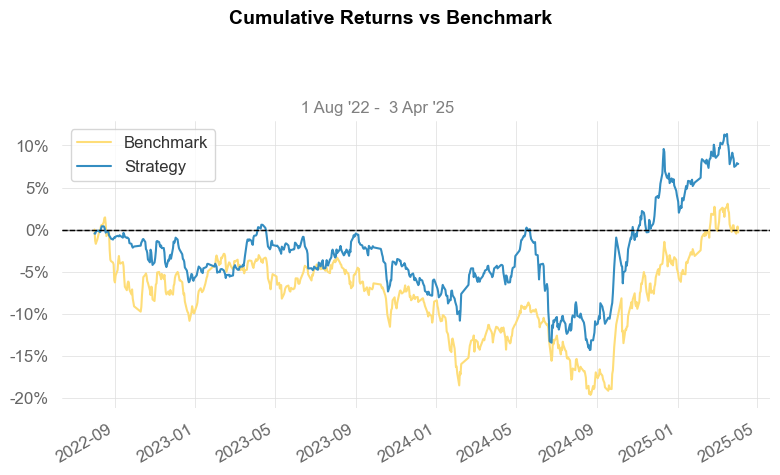

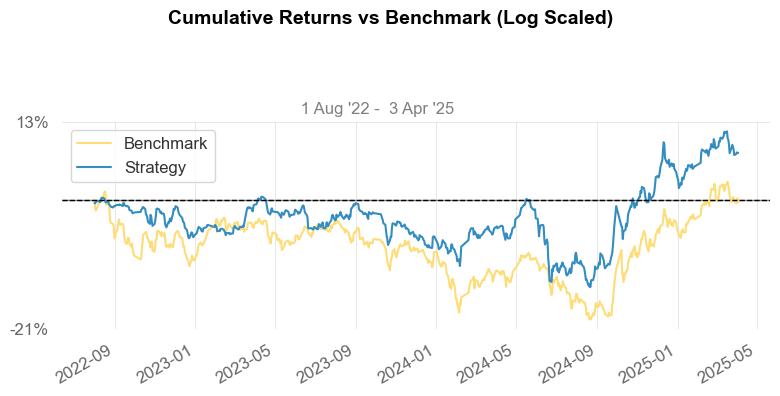

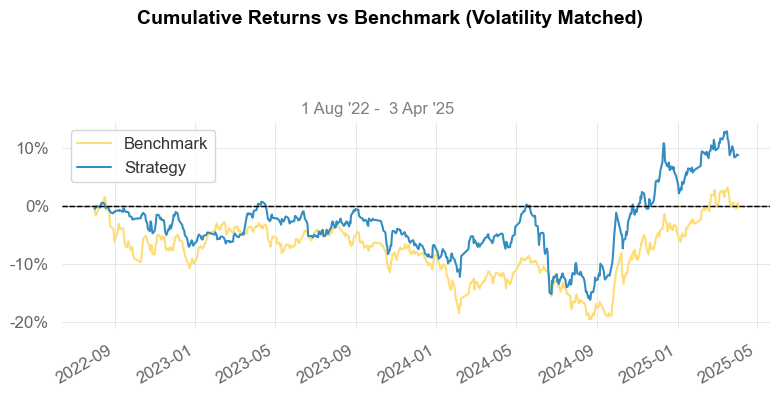

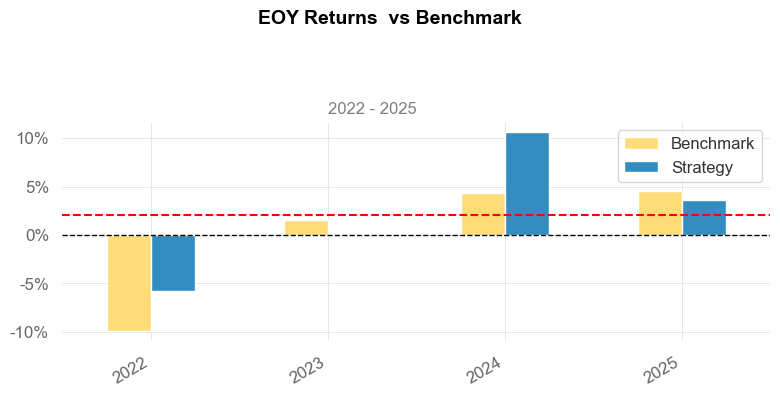

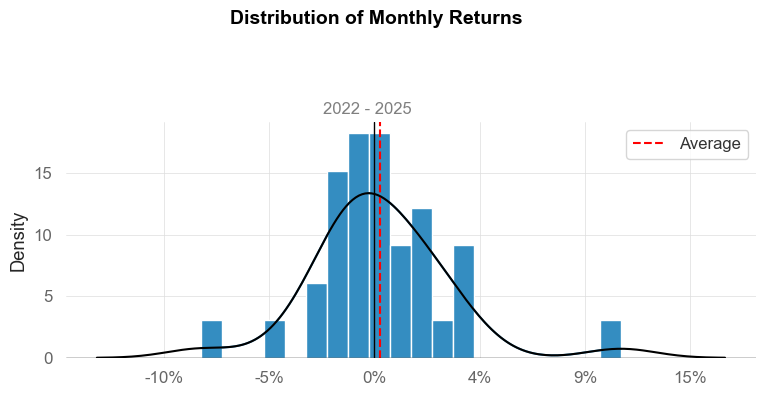

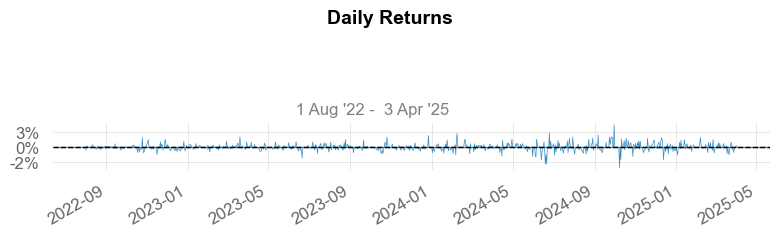

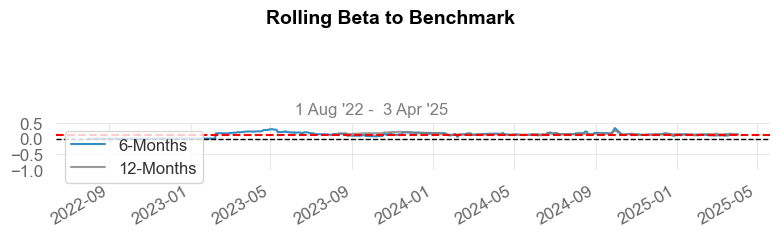

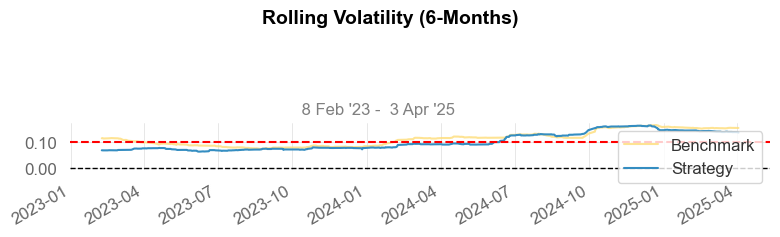

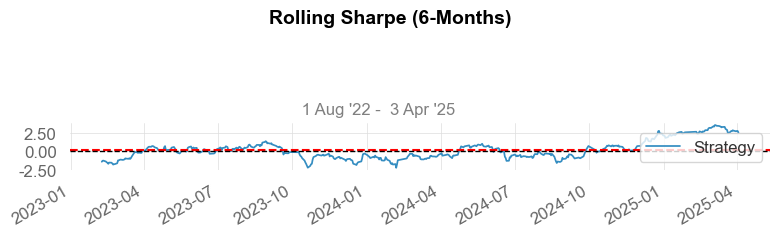

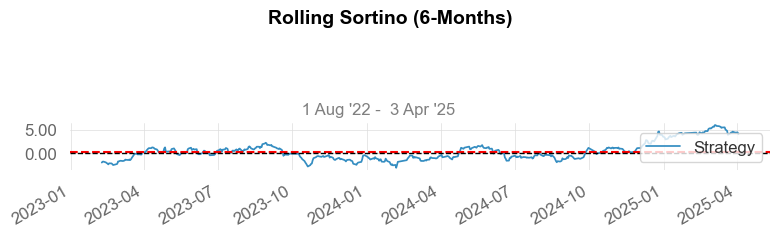

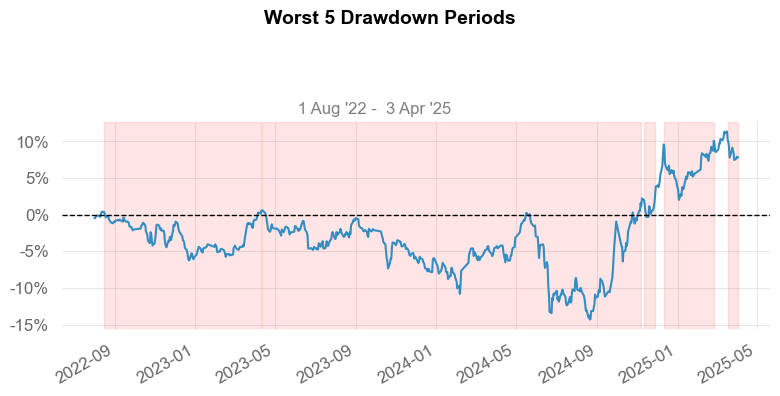

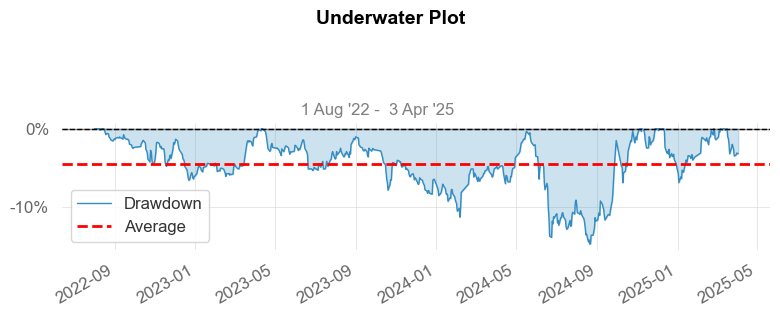

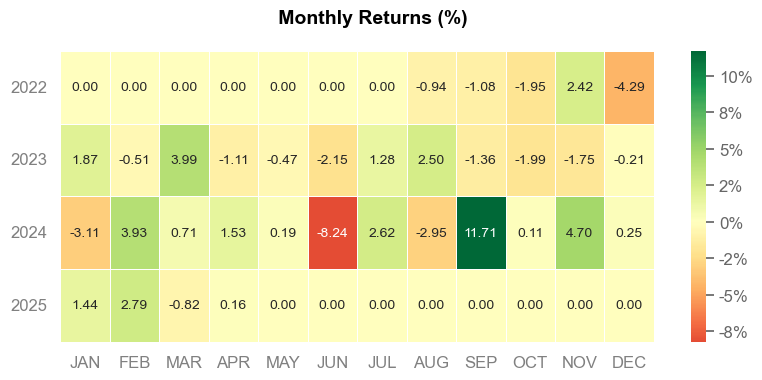

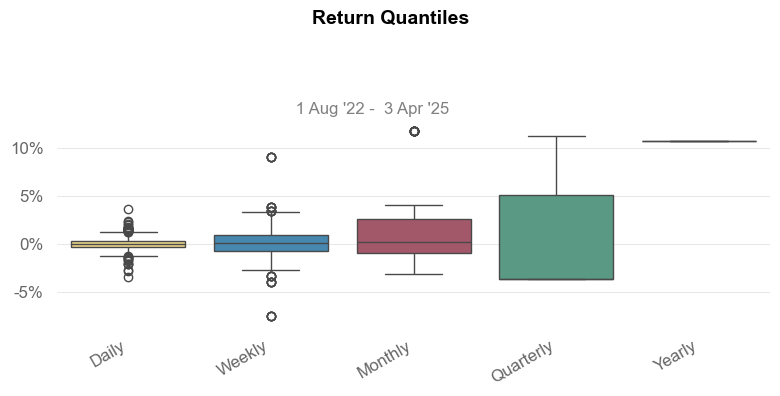

In [9]:
# qs.reports.full(res.time_return, benchmark=index[benchmark], periods_per_year=12)
qs.reports.full(res.time_return, benchmark=index[benchmark])

In [10]:
# 查看某个交易日选出的标的
df.loc[idx[:,'2025-03-13'],:].sort_values(by='rank') # 查看某日

,,name,pre_close,open,high,low,close,limit,close_ma_5,bias_5,pct_chg,adj_factor,vol,vol_5,amount,amount_5,volatility,code_stk,name_stk,pre_close_stk,open_stk,high_stk,low_stk,close_stk,pct_chg_stk,adj_factor_stk,vol_stk,amount_stk,pe_ttm,pb,ps_ttm,dv_ratio,total_share,float_share,total_mv,circ_mv,debt_to_assets,volatility_stk,is_call,conv_price,conv_value,conv_prem,dblow,issue_size,remain_size,remain_cap,turnover,turnover_5,cap_mv_rate,list_date,list_days,conv_start_date,left_conv_start_days,conv_end_date,left_years,ytm,pure_value,bond_prem,option_value,theory_value,theory_bias,rating,yy_rating,orgform,area,industry_1,industry_2,industry_3,maturity_put_price,maturity,popularity_ranking,pct_chg_5,pct_chg_5_stk,alpha_pct_chg_5,theory_conv_prem,mod_conv_prem,open_pct_chg,high_pct_chg,low_pct_chg,max_value,max_value_position,filter,zhengfu,natr_1,natr_3,natr_5,natr_10,natr_20,zhengfu_cha,aft_high1,aft_high_cur_close,turnover_pct,cap_float_share_rate,pct_chg_20,pct_chg_stk_20,turnover_5_avg,turnover_10_avg,turnover_20_avg,turnover_60_avg,rolling_1_avg,rolling_5_avg,rolling_20_avg,rolling_50_avg,rolling_1_to_5_avg,rolling_5_to_20_avg,rolling_20_to_50_avg,turnover_pct_5_avg,bodong_60,bodong_20,bodong_20_to_bodong_60,bodong_20_bd,bodong_10,bodong_10_bd,bodong_5_bd,zhengfu_1,zhengfu_5,zhengfu_10,zhengfu_20,zhengfu_60,zhengfu_1_bodong,zhengfu_5_bodong,zhengfu_10_bodong,zhengfu_20_bodong,zhengfu_60_bodong,high_jump,close_drop,high_jump_count_100,close_drop_count_100,high_jump_count_250,close_drop_count_250,high_jump_count_100_pct,high_jump_count_250_pct,SDZ,close_score,conv_prem_score,remain_size_score,cap_mv_rate_score,theory_bias_score,vol_stk_score,vol_5_score,bias_5_score,turnover_5_score,turnover_score,max_value_position_score,high_jump_count_100_score,close_drop_count_100_score,high_jump_count_250_score,close_drop_count_250_score,bond_prem_score,ytm_score,mod_conv_prem_score,natr_1_score,natr_3_score,natr_5_score,natr_10_score,natr_20_score,remain_cap_score,pct_chg_5_score,zhengfu_5_bodong_score,zhengfu_10_bodong_score,zhengfu_20_bodong_score,zhengfu_60_bodong_score,alpha_pct_chg_5_score,score,rank,aft_open,aft_close,aft_high,time_return,SFZY,signal
code,trade_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
127061.SZ,2025-03-13,美锦转债,103.476,103.400,109.998,103.376,109.007,0,103.7292,0.050881,0.053452,1.097603,1050709.3,2030060.7,113751.896093,214279.054125,0.220825,000723.SZ,美锦能源,4.60,4.60,5.06,4.60,5.06,0.100000,0.440075,2349132.11,1159219.352,NaN,1.5636,1.1022,0.000000,443139.6033,439619.8913,224.228639,222.447665,0.630037,0.392389,None,5.26,96.197719,0.133156,122.322577,35.9000,27.891676,30.403879,0.374136,0.722638,0.135593,2022-05-30,1019,2022-10-26,-869,2028-04-19,3.106849,0.040310,111.258807,-0.020239,26.837467,138.096275,-0.266857,AA-,7-,大型民企,山西,化石能源,煤炭,焦炭,118.0,6.0,7,0.109644,0.204762,-0.095118,0.249689,-0.116533,-0.000734,0.063029,-0.000966,120.500,0.904622,False,0.060748,6.622,3.078644,2.381901,1.714768,1.399535,0.176743,110.378,0.012577,0.882114,0.136679,0.086994,0.165899,0.144528,0.079515,0.049556,0.034466,0.882114,0.651188,0.349614,0.349437,1.354622,1.862593,1.000504,0.651188,0.191939,0.156617,0.815976,0.078192,0.148120,0.072071,0.064147,NaN,0.024466,0.020084,0.014890,0.010047,NaN,0.054708,0.063512,0.066590,0.077822,True,False,4.0,3.0,18.0,11.0,0.351626,0.436992,3445.233123,292.0,220.0,31.0,151.0,290.0,1.0,5.0,1.0,53.0,19.0,93.0,223.5,144.5,188.0,155.0,298.0,2.0,293.0,24.0,42.0,78.0,158.0,222.0,35.0,1.0,6.0,24.0,52.0,113.0,291.0,-2960.0,1.0,108.000,108.830,110.378,-0.001624,未满足止盈,1.0
123049.SZ,2025-03-13,维尔转债,109.600,109.372,110.000,109.131,109.700,0,108.4736,0.011306,0.000912,1.142895,16473.0,75591.6,1807.317860,8213.574122,0.233754,300190.SZ,维尔利,3.29,3.28,3.32,3.24,3.32,0.009119,0.494791,100124.96,32862.192,NaN,0.7361,1.2500,0.002902,78159.7732,77617.3629,25.949045,25.768964,0.569918,0.444660

In [13]:
res.time_return.index

DatetimeIndex(['2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-08', '2022-08-09', '2022-08-10',
               '2022-08-11', '2022-08-12',
               ...
               '2025-03-21', '2025-03-24', '2025-03-25', '2025-03-26',
               '2025-03-27', '2025-03-28', '2025-03-31', '2025-04-01',
               '2025-04-02', '2025-04-03'],
              dtype='datetime64[ns]', name='trade_date', length=648, freq=None)

IndentationError: unexpected indent (2840737331.py, line 9)